In [145]:
import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms import community
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import pathlib
import random

## Getting the bipartite graph

In [227]:
# GLOBALS

BIGRAPH_politi, LABELS_politi = 'user_article_raw.bigraph', "../small_dataset/politifact"
BIGRAPH_gossip, LABELS_gossip = 'user_article_raw_gossipcop.bigraph', "../small_dataset/gossipcop"

BIGRAPH_FILE, LABELS_FILE = BIGRAPH_politi, LABELS_politi
USER_PROFILES_FILE = '../small_dataset/user_profiles/'

In [228]:
# UTILITIES

# Return a set of users who mentioned articles
# Returns 
# dict (users ---> #-mentions)
def get_users_for_article_set(B, articles):
    users_a = dict()
    for a in articles:
        edges = B.edges(a)
        for edge in edges:
            users_a[edge[1]] = users_a.get(edge[1], 0)
    return users_a

def isuser(node):
    return len(node) < 3 or (node[:3] != 'pol' and node[:3] != 'gos')

def get_article_nodes(G):
    return [x for x in list(G.nodes) if (len(x) > 3 and x[:3] == 'pol') or (len(x) > 3 and x[:3] == 'gos')]

def get_user_nodes(G):
    return [x for x in list(G.nodes) if (len(x) < 3 or (x[:3] != 'pol' and x[:3] != 'gos'))]

def get_true_label_dict(datadir, G):
    A_nodes = get_article_nodes(G)
    data_dir = pathlib.Path(datadir)
    label_dic = {}
    for label in ['real', 'fake']:
        label_dir = data_dir / label
        for a in os.listdir(label_dir):
            if a in A_nodes:
                if label == 'real':
                    label_dic[a] = 0
                else:
                    label_dic[a] = 1
    return label_dic
        
def get_article_degrees(G):
    deg_dic = dict()
    A_nodes = get_article_nodes(G)
    for node in A_nodes:
        deg_dic[node] = G.degree[node]
    return deg_dic

def get_all_info_for_articles(degs, labels, G):
    A_nodes = get_article_nodes(G)
    info = dict()
    for node in A_nodes:
        info[node] = (labels[node], degs[node])
    return info

In [229]:
def construct_bipartite(G):
    A_nodes = get_article_nodes(G)
    U_nodes = get_user_nodes(G)
    B = nx.Graph()
    B.add_nodes_from(U_nodes, bipartite=0) 
    B.add_nodes_from(A_nodes, bipartite=1)
    B.add_edges_from(list(G.edges))
    return B

G = nx.readwrite.edgelist.read_edgelist(BIGRAPH_FILE)
B = construct_bipartite(G)

In [210]:
degrees = get_article_degrees(B)
labels = get_true_label_dict(LABELS_FILE, B)
info = get_all_info_for_articles(degrees, labels, B)

In [211]:
# USERS

# Get dataframe consisting of users and their metadata

import json
from json.decoder import JSONDecodeError
import pandas as pd

def get_user_df(userdir):
    user_lists = []
    user_dir = pathlib.Path(userdir)
    for i, ujson in enumerate(os.listdir(user_dir)):
        with open(userdir+ujson, 'r') as f:
            try:
                line = f.readline()
                u = json.loads(line)
                lst = [
                    u['id'], 
                    u['screen_name'],
                    u['verified'],
                    u['followers_count'],
                    u['friends_count'],
                    -1
                ] 
                user_lists.append(lst) 
                if i % 10000 == 0:
                    print(f"Done with {i}")
            except json.decoder.JSONDecodeError:
                pass
    user_df = pd.DataFrame(user_lists, columns=['id', 'scrname', 'verified', 'followers_ct', 'friends_ct', "credibility"])
    return user_df

UDF = get_user_df(USER_PROFILES_FILE)

Done with 0
Done with 10000
Done with 20000
Done with 30000
Done with 40000
Done with 50000


## Models

In [112]:
'''
Model 1

Based on verified users only.
'''

def get_predictions_authored_by_verified(B, verified_users):
    PREDICT_DICT = dict()
    A_nodes = [n for n in B.nodes if B.nodes[n]['bipartite'] == 1]
    for n in A_nodes:
        PREDICT_DICT[n] = 1 # predict fake by default
    for user in verified_users:
        edges = B.edges(str(user))
        for edge in edges:
            PREDICT_DICT[edge[1]] = 0
    return PREDICT_DICT

def model_based_on_verified(G, userdf):
    B = construct_bipartite(G)
    vf_users = list(df[df['verified'] == True]['id'].values)
    predict_dict = get_predictions_authored_by_verified(B, vf_users)
    return predict_dict
    
PREDS_MODEL_1 = model_based_on_verified(B, UDF)

In [ ]:
'''
Model 2

Based on ...??
'''


## Accuracy & prediction evaluation

In [116]:
def accuracy(ACTUALS, PREDS):
    TP, FP, TN, FN = 0,0,0,0
    TPl, FPl, TNl, FNl = [], [], [], []
    for i in PREDS.keys():
        if ACTUALS[i] == 0 and PREDS[i] == 0:
            TN += 1
            TNl.append(i)
        elif ACTUALS[i] == 1 and PREDS[i] == 0:
            FN += 1
            FNl.append(i)
        elif ACTUALS[i] == 0 and PREDS[i] == 1:
            FP += 1
            FPl.append(i)
        elif ACTUALS[i] == 1 and PREDS[i] == 1:
            TP += 1
            TPl.append(i)
    PRECISION = float(TP) / (TP + FP) if (TP + FP) > 0 else -1
    RECALL = float(TP) / (TP + FN) if (TP + FN) > 0 else -1
    ACCURACY = (TP + TN) / (TP + TN + FP + FN)
    print(f"Accuracy: {ACCURACY}\tPrecision: {PRECISION}\tRecall {RECALL}.")
    print(f"TP {TP}, TN {TN}, FP {FP}, FN {FN}")
    print(f"Total amount of samples: {(TP + TN + FP + FN)}")
    return (ACCURACY, PRECISION, RECALL), (TPl, FPl, TNl, FNl)

In [117]:
apr, a = accuracy(LABELS, PREDS_MODEL_1)
(tp, fp, tn, fn) = a

Accuracy: 0.6438356164383562	Precision: 0.7413793103448276	Recall 0.5375.
TP 43, TN 51, FP 15, FN 37
Total amount of samples: 146


## Plots

In [247]:
def get_user_sample_subgraph_from_bgraph(B, pct):
    pctX1000 = pct * 1000
    users = [n for n in B.nodes if B.nodes[n]['bipartite'] == 0]
    articles = [n for n in B.nodes if B.nodes[n]['bipartite'] == 1]
    users_sample = [u for u in users if random.randint(0, 1000) <= pctX1000]
    return B.subgraph(articles + users_sample)

def plot_with_bipartition(B, labels):
    # Separate by group
    l = [n for n in B.nodes if B.nodes[n]['bipartite'] == 0]
    r = [n for n in B.nodes if B.nodes[n]['bipartite'] == 1]
    pos = {}

    # Update position for node from each group
    pos.update((node, (1, index)) for index, node in enumerate(l))
    pos.update((node, (2, index)) for index, node in enumerate(r))
    
    color_map = []
    for node in B.nodes:
        if isuser(node):
            color_map.append("black")
        else:
            if labels[node] == 1: # fake
                color_map.append('red')
            else:
                color_map.append('green')
    
    fig = plt.figure(figsize=(20,15))
    nx.draw(B, pos=pos, node_color=color_map)
    plt.show()

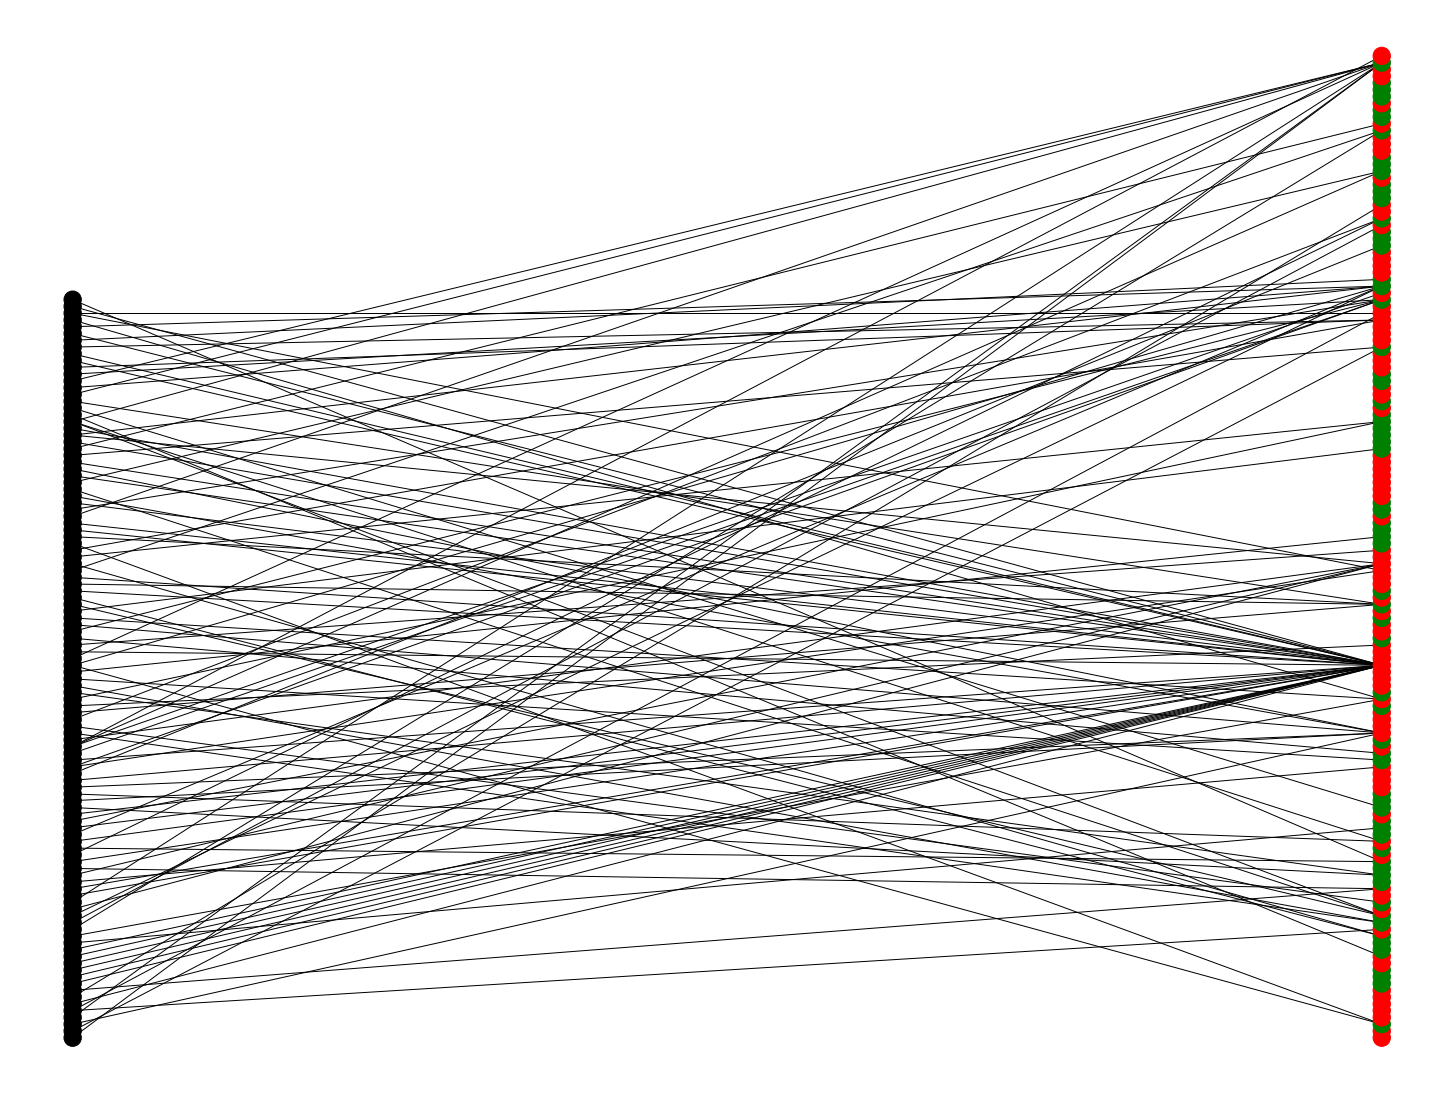

In [249]:
B_usample = get_user_sample_subgraph_from_bgraph(B, 0.001)
plot_with_bipartition(B_usample, labels)